In [95]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import re



from string import punctuation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer , WordNetLemmatizer, LancasterStemmer

from collections import Counter
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scikitplot.metrics import plot_confusion_matrix, plot_roc

from plotly.subplots import make_subplots



In [96]:
# Reading Data

student_depression = pd.read_excel("dataset.xlsx")
student_depression.head(10)

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0
5,"every break, you must be nervous, like somethi...",1.0
6,"I feel scared, anxious, what can I do? And may...",1.0
7,Have you ever felt nervous but didn't know why?,1.0
8,"I haven't slept well for 2 days, it's like I'm...",1.0
9,"I'm really worried, I want to cry.",1.0


In [97]:
student_depression.isnull().sum()

text     10
label     2
dtype: int64

In [98]:
student_depression = student_depression.dropna(how="any")

In [99]:
student_depression["label"].value_counts() 

0.0    6240
1.0     730
Name: label, dtype: int64

0 - A student does not suffer from depression
<br>
1 - A student does suffer from depression

The table clearly shows that there are more students that don't suffer from depression.

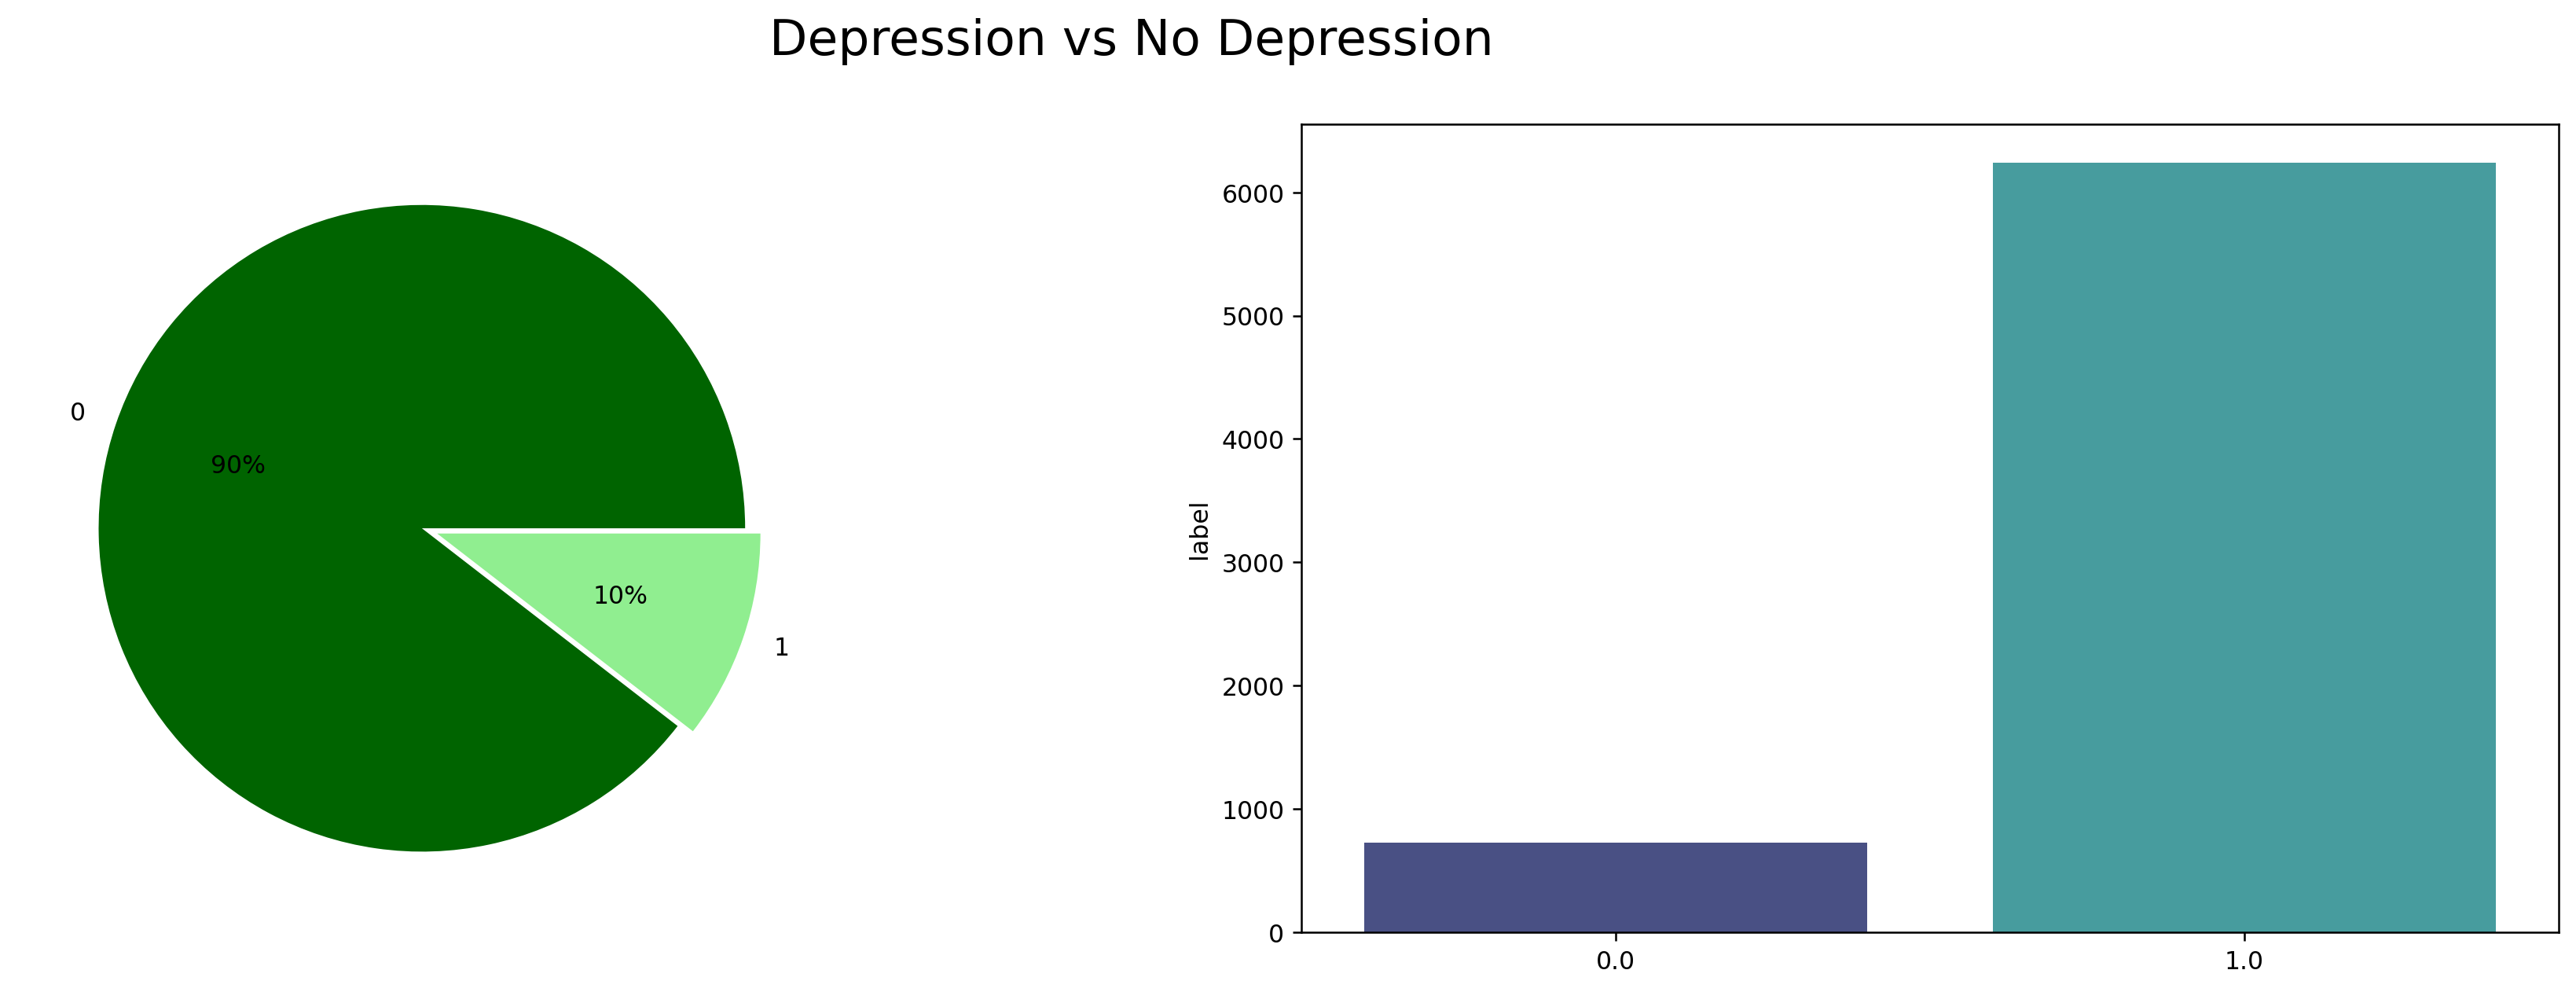

In [100]:
labels = [0,1]
sizes = [6240,730]

plt.figure(figsize=(20,6),dpi=227)
plt.subplot(1,2,1)
plt.pie(sizes, labels=labels,autopct = '%1.0f%%', explode=[0,0.05], colors = ['darkgreen', 'lightgreen'])

plt.subplot(1,2,2)
sns.barplot(x = student_depression["label"].unique(),y = student_depression["label"].value_counts(), palette = "mako")


plt.suptitle("Depression vs No Depression",fontsize = 20)
plt.show()

# Adding Features

In [101]:
def total_chars(data):
    counter = 0
    for word in data.split():
        counter += len(word)
    return counter

def total_punc(data):
    counter = 0
    for i in range(len(data)):
        if data[i] in punctuation:
            counter += 1
    return counter

def avg_word_length(data):
    list_of_lengths = []
    for word in word_tokenize(data):
        list_of_lengths.append(len(word))
    return sum(list_of_lengths)

def total_vowels(data):
    counter = 0
    for word in word_tokenize(data):
        for letter in word.lower():
            if letter in "aeiou":
                counter += 1
    return counter

student_depression["total_words"] = student_depression["text"].apply(lambda x: len(x.split(" ")))

student_depression["total_chars"] = student_depression["text"].apply(total_chars)

student_depression["total_spaces"] = student_depression["total_words"] - 1

student_depression["avg_word_length"] = student_depression["text"].apply(lambda x: avg_word_length(x)/len(word_tokenize(x)))

student_depression["total_vowels"] = student_depression["text"].apply(lambda x:total_vowels(x))


# Total Number of Words: In Depression vs Not In Depression

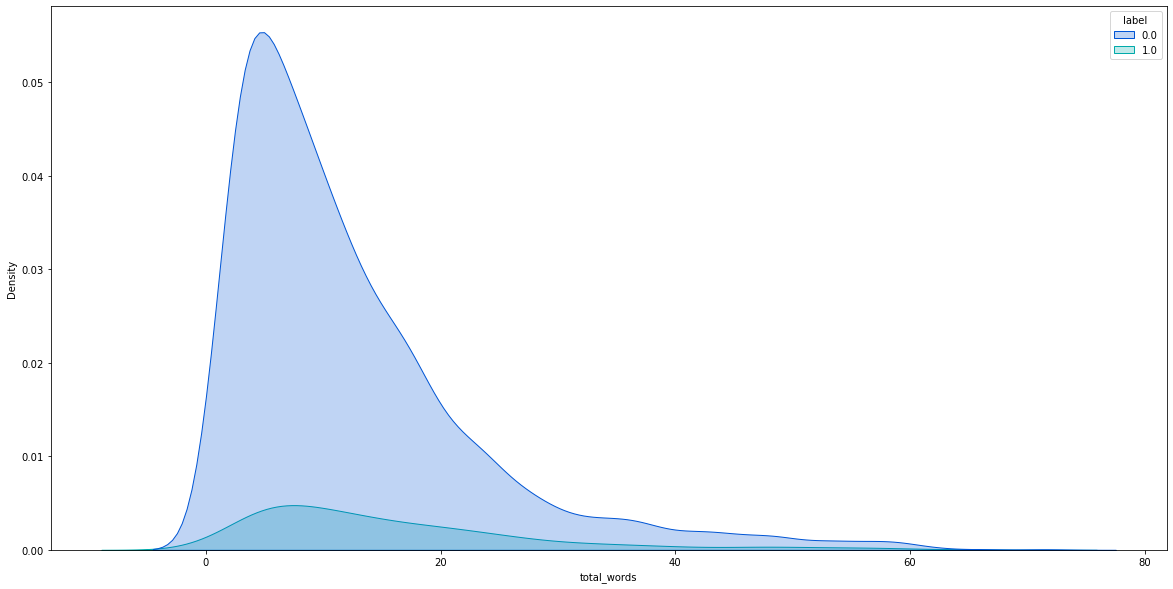

In [102]:
plt.figure(figsize = (20, 10))
sns.kdeplot(x = student_depression['total_words'], 
            hue= student_depression['label'],
            palette= 'winter', 
            shade = True)
plt.show()

# Total Number of Characters: In Depression vs Not In Depression

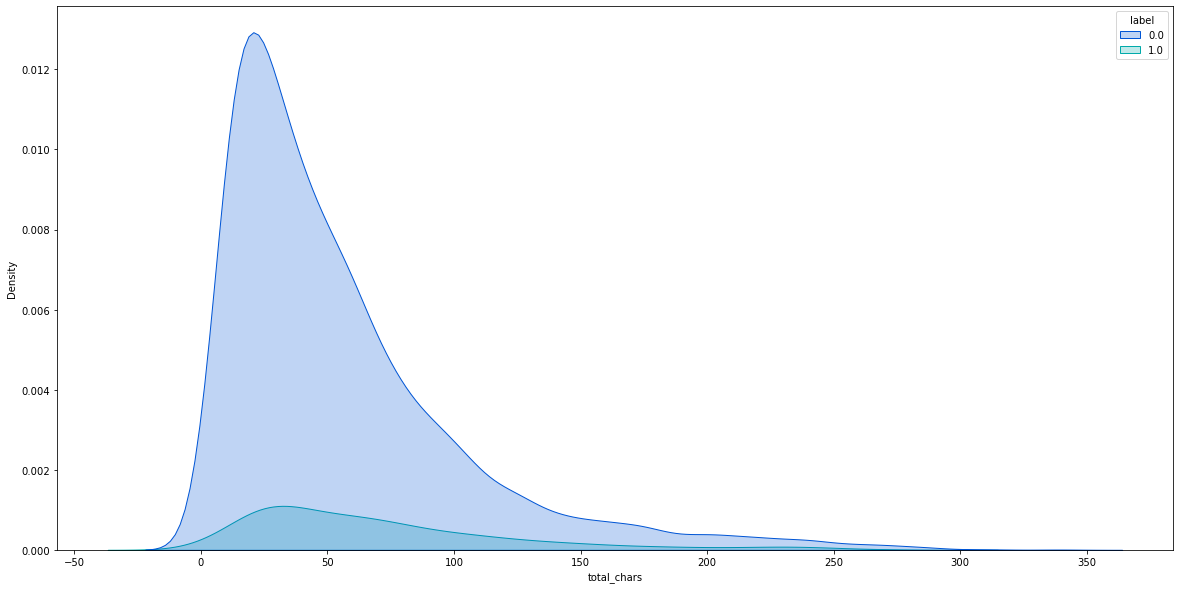

In [103]:
plt.figure(figsize = (20, 10))
sns.kdeplot(x = student_depression['total_chars'], 
            hue= student_depression['label'],
            palette= 'winter', 
            shade = True)
plt.show()

# Text Preprocessing

In [104]:
stop_words = stopwords.words("english")
stemmer = PorterStemmer()
lematizer = WordNetLemmatizer()

def remove_puncs(text): # Removing punctuations
    punc_free = ''.join([char for char in text if char not in punctuation])
    return punc_free

def remove_stop_words(text): # Stop words remover
    stop_words_free = [word for word in text if word not in stop_words]
    return stop_words_free

def remove_numbers(text):
    res = ''
    numbers_free = []
    for word in text:
        for c in word:
            if not c.isdigit():
                res += c
        numbers_free.append(res)
        res = ''
    return numbers_free

def stemming(text): # Stem the word with losing the meaning 
    stemmed_text = [stemmer.stem(word) for word in text]
    return stemmed_text

def lemmatizator(text): # Stem the words without losing the meaning
    lema_text = [lematizer.lemmatize(word) for word in text]
    return lema_text

student_depression["original_text"] = student_depression["text"] # New col to hold the original text.
student_depression["text"] = student_depression["text"].apply(lambda x: remove_puncs(x)) # Removing punctuations
student_depression["text"] = student_depression["text"].apply(lambda x : x.lower()) # lower case every sentence
student_depression["text"] = student_depression["text"].apply(lambda x : word_tokenize(x)) # list of all words.
student_depression["text"] = student_depression["text"].apply(lambda x : remove_stop_words(x)) # Stop words remover
student_depression["text"] = student_depression["text"].apply(lambda x : lemmatizator(x)) # Stem without losing meaning
student_depression["text"] = student_depression["text"].apply(lambda x: remove_numbers(x)) # removing numbers
student_depression["text"] = student_depression["text"].apply(lambda x : ' '.join(x)) # New Text.


# Most commonly used words when in depression & not in depression

In [105]:
def most_used_words(list_of_sentences, cols_names):
    res = []
    for sentence in list_of_sentences:
        for word in sentence.split():
            res.append(word)
    return pd.DataFrame(Counter(res).most_common(25),columns=cols_names)

no_dep_sentences = student_depression[student_depression["label"] == 0]["text"].to_list()
dep_sentences = student_depression[student_depression["label"] == 1]["text"].to_list()

no_dep_words_df = most_used_words(no_dep_sentences,
                                  ["No Dep Words","Frequency"]).sort_values("Frequency", ascending=False)
dep_words_df = most_used_words(dep_sentences, 
                               ["Dep Words","Frequency"]).sort_values("Frequency", ascending=False)

In [106]:
no_dep_words_bar = px.bar(no_dep_words_df.head(15), 
                          x="Frequency",
                          y="No Dep Words",
                          color="No Dep Words",
                          title= "Most commonly used words when the student is not in depression")

no_dep_words_bar.add_vrect(x0=295,
                           x1=no_dep_words_df["Frequency"].head(15).mean(),
                           fillcolor="black", 
                           opacity=0.5, 
                           line_width=0)

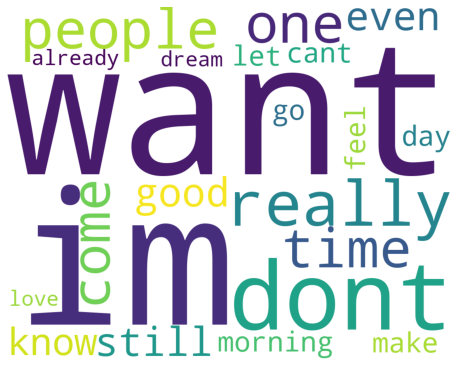

In [107]:
no_dep_words = no_dep_words_df["No Dep Words"].to_list()

plt.subplots(figsize=(8,8))

no_dep_words_cloud = WordCloud(
    background_color = 'white',
    width = 1000,
    height = 800
).generate(' '.join(no_dep_words))

plt.imshow(no_dep_words_cloud)
plt.axis('off')
plt.show()

In [108]:
dep_words_bar = px.bar(dep_words_df.head(15), 
                       x="Frequency",
                       y="Dep Words",
                       color="Dep Words",
                       title = "Most commonly used words when the student is in depression")

dep_words_bar.add_vrect(x0=120, x1=dep_words_df["Frequency"].head(15).mean(),
              fillcolor="black", opacity=0.5, line_width=0)


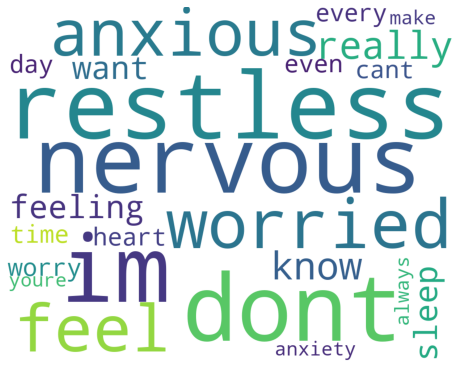

In [109]:
dep_words = dep_words_df["Dep Words"].to_list()

plt.subplots(figsize=(8,8))

dep_words_cloud = WordCloud(
    background_color = 'white',
    width = 1000,
    height = 800
).generate(' '.join(dep_words))

plt.imshow(dep_words_cloud)
plt.axis('off')
plt.show()

# Sentimental Analysis

## Positive & Negative Analysis

In [110]:
analyzer = SentimentIntensityAnalyzer()

student_depression['rating'] = student_depression['text'].apply(analyzer.polarity_scores)
student_depression = pd.concat([student_depression.drop(['rating'], axis=1), 
                                student_depression['rating'].apply(pd.Series)], axis=1)

student_depression.rename(columns = {"neg":"negative",
                                     "neu":"neutral",
                                     "pos":"positive"},inplace=True)


In [111]:
px.box(student_depression, 
       x="label",
       y="positive",
       color="label",
       points="suspectedoutliers",
       title="Positive Vs Label",
       width = 800,
       height=500)

In [112]:
px.box(student_depression, 
       x="label",
       y="negative",
       color="label",
       points="suspectedoutliers" ,
       title="Negative Vs Label",
       width = 800,
       height=500)

In [113]:
px.box(student_depression, 
       x="label",
       y="neutral",
       color="label",
       points="suspectedoutliers" ,
       title="Neutral Vs Label",
       width = 800,
       height=500)

By plotting these boxplots I can clearly tell there are some outliers in the data, or at least a value who's big/small enough to be suspected as one. Therefore, I might be needed to take action and clean the data before training my model.

In [114]:
def outlier_cleaner(data,quant): # function for future use.
    high = np.precentile(data,quant)
    return np.where(data>high,high,data)

# Test & Train Split

In [115]:
text = student_depression["text"]
labels = student_depression['label'].values

text_train, text_test, labels_train, labels_test = train_test_split(text, labels, 
                                                                    test_size= 0.2, 
                                                                    random_state= 42, 
                                                                    stratify = labels)

tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
text_train = tfidf.fit_transform(text_train).toarray()
text_test = tfidf.transform(text_test).toarray()

In [116]:
def model_training(model):
    model.fit(text_train,labels_train)
    labels_pred = model.predict(text_test)
    labels_prob = model.predict_proba(text_test)
    accu = round(accuracy_score(labels_test,labels_pred),3)
    precision = round(precision_score(labels_test,labels_pred),3)
    recall = round(recall_score(labels_test, labels_pred), 3)
    print(f"Model's Accuracy:{accu}")
    print(f"Model's Precision:{precision}")
    print(F"Model's recall:{recall}")
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = plot_confusion_matrix(labels_test, labels_pred, ax= ax[0], cmap= 'YlGnBu')
    ax2 = plot_roc(labels_test, labels_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

# Multinomial Naive Bayes

Model's Accuracy:0.936
Model's Precision:1.0
Model's recall:0.39


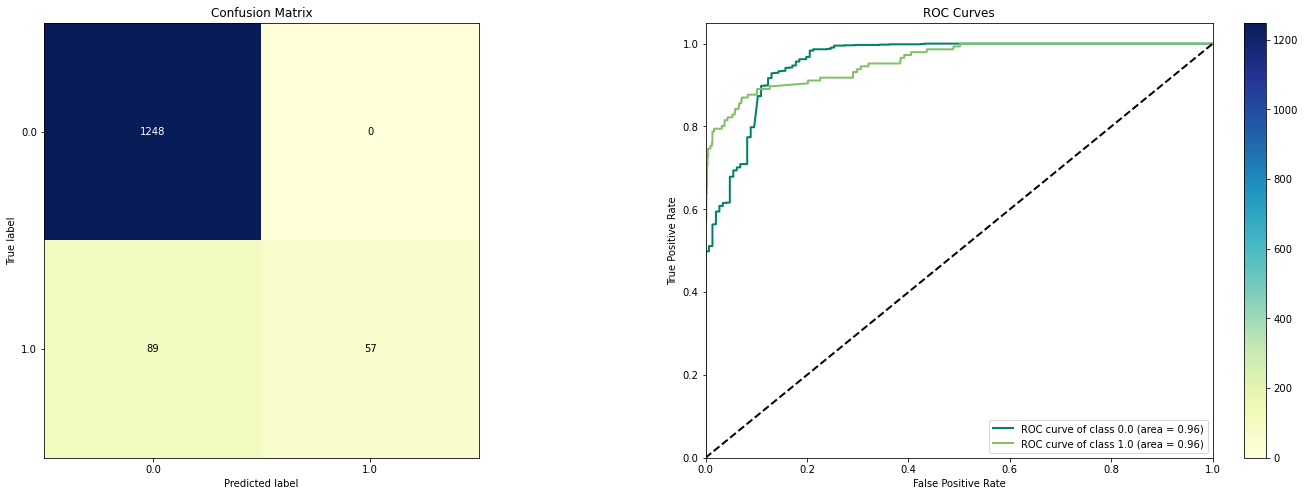

In [117]:
nb = MultinomialNB()
model_training(nb)

# Random Forest 

Model's Accuracy:0.989
Model's Precision:0.978
Model's recall:0.911


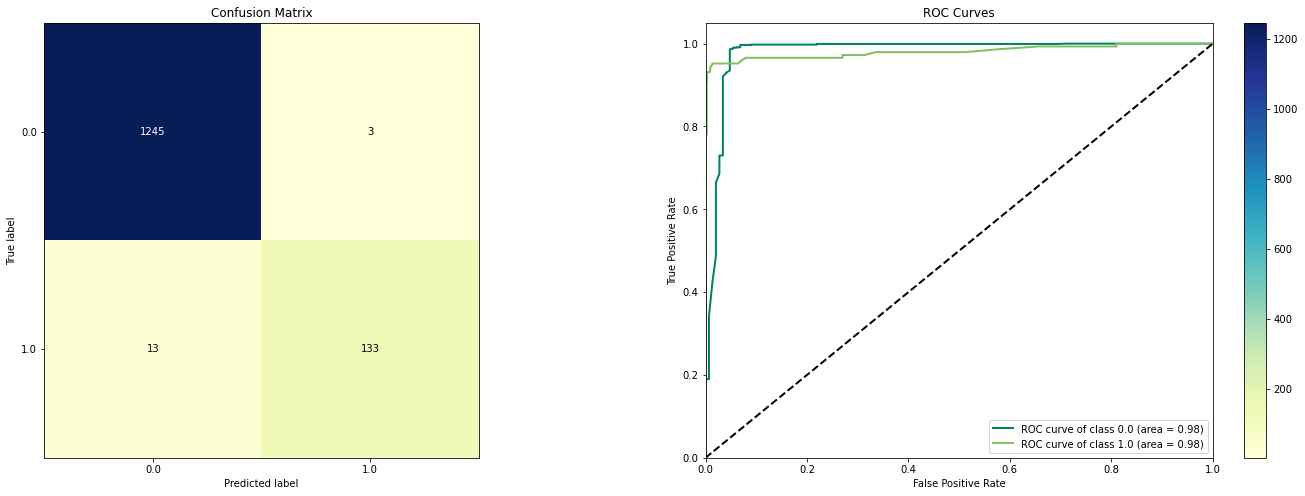

In [118]:
rf = RandomForestClassifier(n_estimators=200)
model_training(rf)

Model's Accuracy:0.966
Model's Precision:0.938
Model's recall:0.726


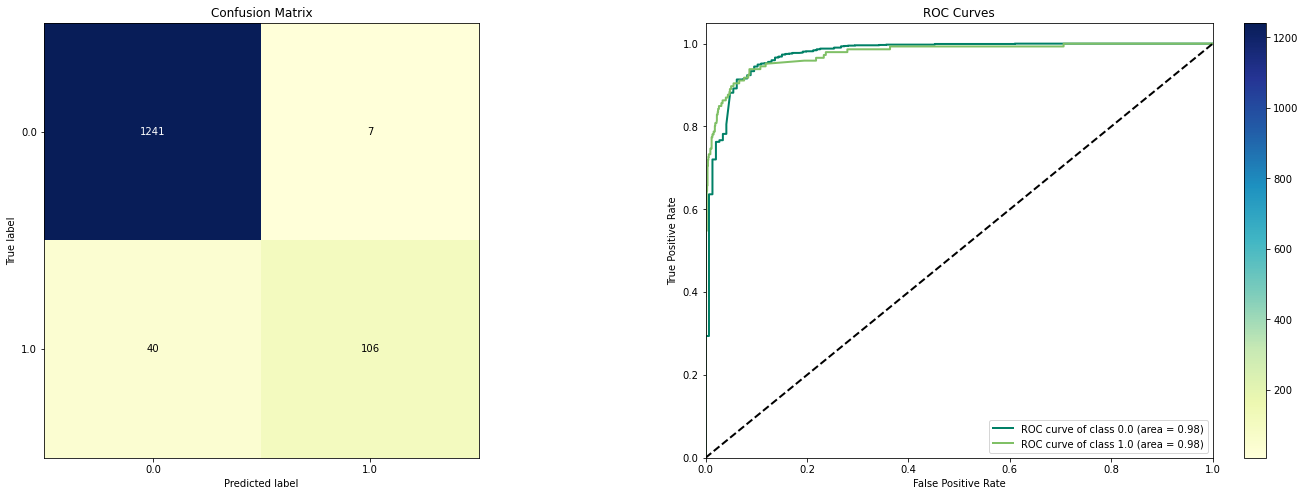

In [119]:
nnk = MLPClassifier()
model_training(nnk)